### NATURAL LANGUAGE UNDERSTANDING

### ASSIGNMENT - 1

Submitted By:

Pooja Naveen Poonia (M24CSA020), Pranjal Malik (M24CSA021), Shivani Tiwari (M24CSA029), Suvigya Sharma (M24CSA033)



Question:  
Part-of-speech (PoS) tagging assigns grammatical categories to every token in a
sentence. In this assignment, you must develop a PoS tagger using the following
HMM configurations.  
a. First Order HMM and assuming that  the probability of a word depends
only on the current tag  
b. Second Order HMM, and assuming that the probability depends only on
the current tag   
c. First Order HMM and assuming the Probability of a word depends on the
current tag as well as on the previous word


**Dataset Used** : English Penn Treebank (PTB) corpus

In [ ]:
# Importing Libraries
import json
import random
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Loading Dataset

In [ ]:
# Set random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Load the JSON dataset
def load_json_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    sentences = []
    for entry in data:
        sentence = list(zip(entry[0].split(), entry[1]))
        sentences.append(sentence)
    return sentences

# Split dataset into 80:20
def split_data(sentences, train_ratio=0.8):
    random.shuffle(sentences)
    split_idx = int(len(sentences) * train_ratio)
    return sentences[:split_idx], sentences[split_idx:]

In [ ]:
# Collapse 36 tags to 4 tags
def collapse_tags(sentence):
    collapsed_sentence = []
    for word, tag in sentence:
        if tag in ['NN', 'NNS', 'NNP', 'NNPS']:
            collapsed_sentence.append((word, 'N'))
        elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            collapsed_sentence.append((word, 'V'))
        elif tag in ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']:
            collapsed_sentence.append((word, 'A'))
        else:
            collapsed_sentence.append((word, 'O'))
    return collapsed_sentence


# Compute emission and transition probabilities
def train_hmm(sentences, order=1, use_prev_word=False):
    transition_counts = defaultdict(lambda: defaultdict(int))
    emission_counts = defaultdict(lambda: defaultdict(int))
    tag_counts = defaultdict(int)
    word_counts = defaultdict(int)

    for sentence in sentences:
        prev_tag = None
        prev_prev_tag = None
        for i, (word, tag) in enumerate(sentence):
            tag_counts[tag] += 1
            word_counts[word] += 1
            emission_counts[tag][word] += 1

            if order == 1:
                if use_prev_word and i > 0:
                    transition_counts[(prev_tag, sentence[i-1][0])][tag] += 1
                else:
                    transition_counts[prev_tag][tag] += 1
            elif order == 2:
                transition_counts[(prev_prev_tag, prev_tag)][tag] += 1

            prev_prev_tag = prev_tag
            prev_tag = tag

    # Normalize probabilities
    transition_probs = {k: {k2: v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in transition_counts.items()}
    emission_probs = {k: {k2: v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in emission_counts.items()}
    tag_probs = {k: v / sum(tag_counts.values()) for k, v in tag_counts.items()}

    return transition_probs, emission_probs, tag_probs, tag_counts

# Find the most frequent tag for unseen words
def find_most_frequent_tag(tag_counts):
    return max(tag_counts, key=tag_counts.get)

# Viterbi Algorithm for decoding
def viterbi(sentence, transition_probs, emission_probs, tag_probs, most_frequent_tag, order=1, use_prev_word=False):
    n = len(sentence)
    states = list(tag_probs.keys())
    dp = [{} for _ in range(n)]
    backpointer = [{} for _ in range(n)]

    for state in states:
        word = sentence[0]
        dp[0][state] = tag_probs.get(state, 1e-6) * emission_probs.get(state, {}).get(word, 1e-6)
        backpointer[0][state] = None

    for i in range(1, n):
        word = sentence[i]
        prev_word = sentence[i-1] if i > 0 else None
        for state in states:
            max_prob, best_prev_state = 0, None
            for prev_state in states:
                trans_key = (prev_state, prev_word) if use_prev_word else prev_state
                if state in transition_probs.get(trans_key, {}):
                    transition_prob = transition_probs[trans_key][state]
                else:
                    transition_prob = 1e-6

                if word not in emission_probs.get(state, {}):
                    emission_prob = 1e-6
                else:
                    emission_prob = emission_probs[state][word]

                prob = dp[i-1].get(prev_state, 1e-6) * transition_prob * emission_prob
                if prob > max_prob:
                    max_prob, best_prev_state = prob, prev_state
            dp[i][state] = max_prob
            if best_prev_state is None:
                best_prev_state = most_frequent_tag
            backpointer[i][state] = best_prev_state


    best_final_state = max(dp[-1], key=dp[-1].get) if dp[-1] else most_frequent_tag
    best_sequence = [best_final_state]
    for i in range(n-1, 0, -1):
        prev_tag = backpointer[i].get(best_sequence[0], most_frequent_tag)
        if prev_tag is None:
            prev_tag = most_frequent_tag
        best_sequence.insert(0, prev_tag)

    return best_sequence

# Evaluate model accuracy
def evaluate_model(test_data, transition_probs, emission_probs, tag_probs, most_frequent_tag, order=1, use_prev_word=False):
    correct = 0
    total = 0
    tag_wise_correct = defaultdict(int)
    tag_wise_total = defaultdict(int)

    for sentence in test_data:
        words, true_tags = zip(*sentence)
        predicted_tags = viterbi(words, transition_probs, emission_probs, tag_probs, most_frequent_tag, order, use_prev_word)

        for pred, true in zip(predicted_tags, true_tags):
            if pred == true:
                correct += 1
                tag_wise_correct[true] += 1
            tag_wise_total[true] += 1
        total += len(sentence)

    overall_accuracy = correct / total
    tag_wise_accuracy = {tag: tag_wise_correct[tag] / tag_wise_total[tag] for tag in tag_wise_total}
    return overall_accuracy, tag_wise_accuracy

# Load and preprocess data
data = load_json_data("/content/penn-data.json")
train_data, test_data = split_data(data)


# Evaluate 36-tag vs 4-tag model
train_data_4tag = [collapse_tags(sentence) for sentence in train_data]
test_data_4tag = [collapse_tags(sentence) for sentence in test_data]

# Train models for each HMM variation
for order, use_prev_word in [(1, False), (2, False), (1, True)]:
    transition_probs_36, emission_probs_36, tag_probs_36, tag_counts_36 = train_hmm(train_data, order, use_prev_word)
    transition_probs_4, emission_probs_4, tag_probs_4, tag_counts_4 = train_hmm(train_data_4tag, order, use_prev_word)

    most_frequent_tag_36 = find_most_frequent_tag(tag_counts_36)
    most_frequent_tag_4 = find_most_frequent_tag(tag_counts_4)

    accuracy_36, tag_acc_36 = evaluate_model(test_data, transition_probs_36, emission_probs_36, tag_probs_36, most_frequent_tag_36, order, use_prev_word)
    accuracy_4, tag_acc_4 = evaluate_model(test_data_4tag, transition_probs_4, emission_probs_4, tag_probs_4, most_frequent_tag_4, order, use_prev_word)

    print(f"Order: {order}, Use Previous Word: {use_prev_word}")
    print(f"Overall Accuracy (36-tag model): {accuracy_36:.4f}")
    print(f"Tag-wise Accuracy (36-tag model): {tag_acc_36}")
    print(f"Overall Accuracy (4-tag model): {accuracy_4:.4f}")
    print(f"Tag-wise Accuracy (4-tag model): {tag_acc_4}")

Order: 1, Use Previous Word: False
Overall Accuracy (36-tag model): 0.8767
Tag-wise Accuracy (36-tag model): {'NNS': 0.7550505050505051, 'VBD': 0.8634920634920635, 'VBN': 0.7312072892938497, 'IN': 0.9741334712881531, 'DT': 0.9930511686670878, 'PRP': 0.9756838905775076, 'EX': 0.9411764705882353, 'MD': 0.9877300613496932, 'VB': 0.893223819301848, 'NN': 0.8801619433198381, 'TO': 1.0, 'PRP$': 0.99375, 'CC': 0.9907834101382489, 'VBG': 0.6387959866220736, 'JJ': 0.8101933216168717, 'NNP': 0.8790623335109217, 'VBZ': 0.8605263157894737, 'WRB': 0.9767441860465116, 'RB': 0.7690802348336595, 'CD': 0.7372488408037094, 'VBP': 0.76, 'WP': 0.9767441860465116, 'NNPS': 0.5, 'WDT': 0.9139784946236559, 'JJS': 0.9428571428571428, 'JJR': 0.8674698795180723, ':': 1.0, 'RP': 0.717391304347826, 'UH': 0.0, 'RBR': 0.35714285714285715, '-LRB-': 1.0, '-RRB-': 1.0, 'LS': 0.0, "''": 1.0, 'RBS': 1.0, 'PDT': 0.5, 'WP$': 1.0, '#': 1.0}
Overall Accuracy (4-tag model): 0.8943
Tag-wise Accuracy (4-tag model): {'N': 0.9006

Evaluation of Part-of-Speech Tagging Model: Confusion Matrix and Per-Tag Accuracy

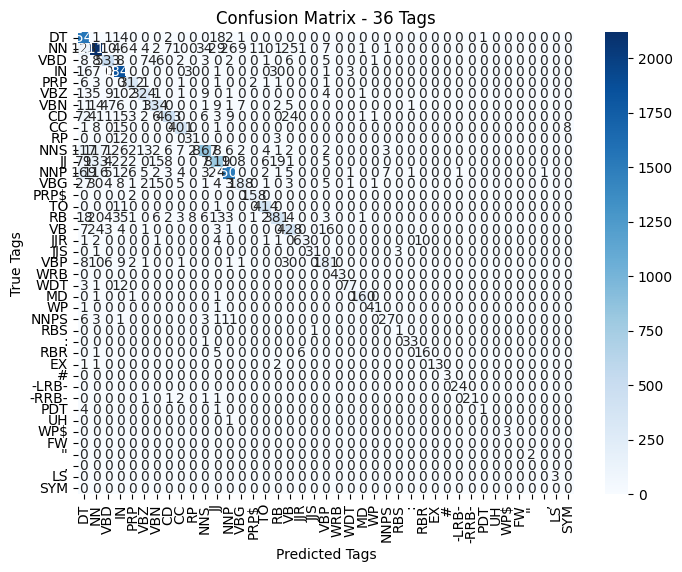

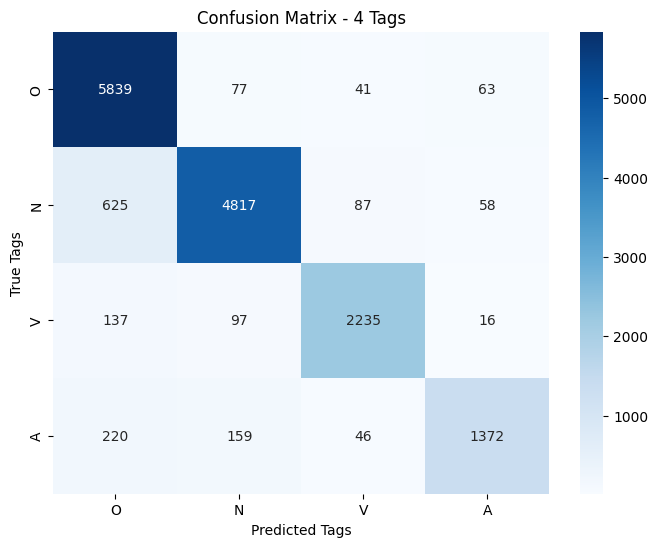

<ipython-input-4-19690520ace8>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tags, y=accuracies, palette="viridis")


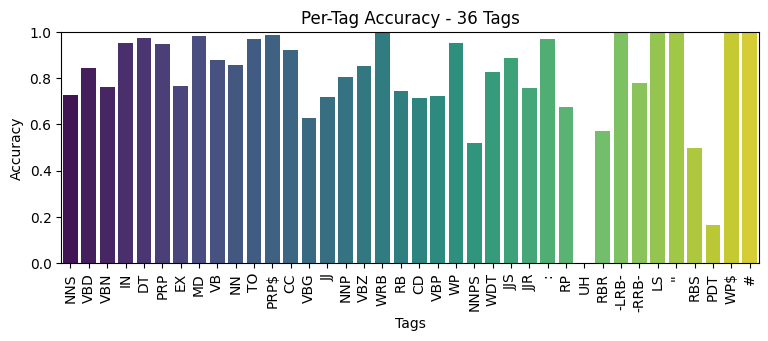

<ipython-input-4-19690520ace8>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tags, y=accuracies, palette="viridis")


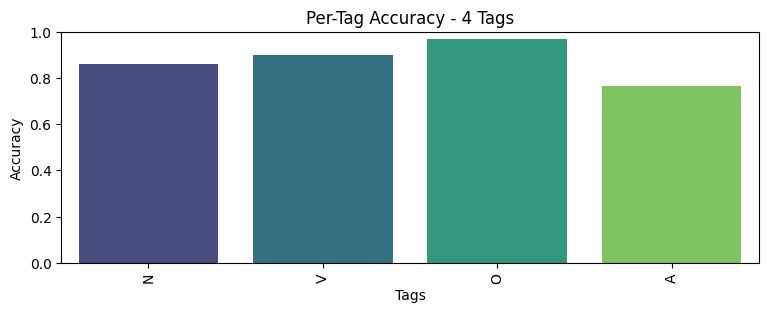

In [ ]:
def plot_confusion_matrix(true_tags, pred_tags, tag_list, title="Confusion Matrix"):
    cm = confusion_matrix(true_tags, pred_tags, labels=tag_list)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tag_list, yticklabels=tag_list)
    plt.xlabel("Predicted Tags")
    plt.ylabel("True Tags")
    plt.title(title)
    plt.show()

def plot_per_tag_accuracy(tag_wise_accuracy, title="Per-Tag Accuracy"):
    tags = list(tag_wise_accuracy.keys())
    accuracies = list(tag_wise_accuracy.values())

    plt.figure(figsize=(9, 3))
    sns.barplot(x=tags, y=accuracies, palette="viridis")
    plt.xticks(rotation=90)
    plt.ylabel("Accuracy")
    plt.xlabel("Tags")
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

# Collect true and predicted tags
def collect_predictions(test_data, transition_probs, emission_probs, tag_probs, most_frequent_tag, order=1, use_prev_word=False):
    true_tags = []
    pred_tags = []

    for sentence in test_data:
        words, sentence_true_tags = zip(*sentence)
        sentence_pred_tags = viterbi(words, transition_probs, emission_probs, tag_probs, most_frequent_tag, order, use_prev_word)
        true_tags.extend(sentence_true_tags)
        pred_tags.extend(sentence_pred_tags)

    return true_tags, pred_tags

true_tags_36, pred_tags_36 = collect_predictions(test_data, transition_probs_36, emission_probs_36, tag_probs_36, most_frequent_tag_36, order, use_prev_word)
true_tags_4, pred_tags_4 = collect_predictions(test_data_4tag, transition_probs_4, emission_probs_4, tag_probs_4, most_frequent_tag_4, order, use_prev_word)

tag_list_36 = list(tag_probs_36.keys())
tag_list_4 = list(tag_probs_4.keys())

plot_confusion_matrix(true_tags_36, pred_tags_36, tag_list_36, title="Confusion Matrix - 36 Tags")
plot_confusion_matrix(true_tags_4, pred_tags_4, tag_list_4, title="Confusion Matrix - 4 Tags")

plot_per_tag_accuracy(tag_acc_36, title="Per-Tag Accuracy - 36 Tags")
plot_per_tag_accuracy(tag_acc_4, title="Per-Tag Accuracy - 4 Tags")
